In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')
path = "gdrive/My Drive/COMP90086T/Week 9/"

Mounted at /content/gdrive/


In [ ]:
# Bringing all .py modules to the same directory as this file
!cp -a /content/gdrive/MyDrive/COMP90086T/Week\ 9/. .

# COMP90086 Week 9: Texture Synthesis and Shaping

In this workshop, you will see some demonstrations about texture and shape representation.

Table of Contents

- Texture and shape representation
    - Image Quilting
    - Parametric Texture Synthesis
    - Neural Style Transfer
    - Shape skeletons
    - Active contours
    
- Bonus
    - Texture Transfer

### Assignment 2 Feedback
Common problems: Presentation!
- Images too small to look at
- No supporting evidences
- 'Seems like a have b': Needs to be more specified
- Screenshot output/folder: You can use these alternatives:
  - Confusion matrix: `sns.heatmap()`
  - Class-based accuracy: Use tables, or bar charts like `plt.bar()`
  - Label distribution: Bar chart, or pie chart
  - Make use of `plt.subplots()` when displaying multiple plots.
- Informal format/wording

Prepare your presentation well, as you will have to write a formal report for the big project!

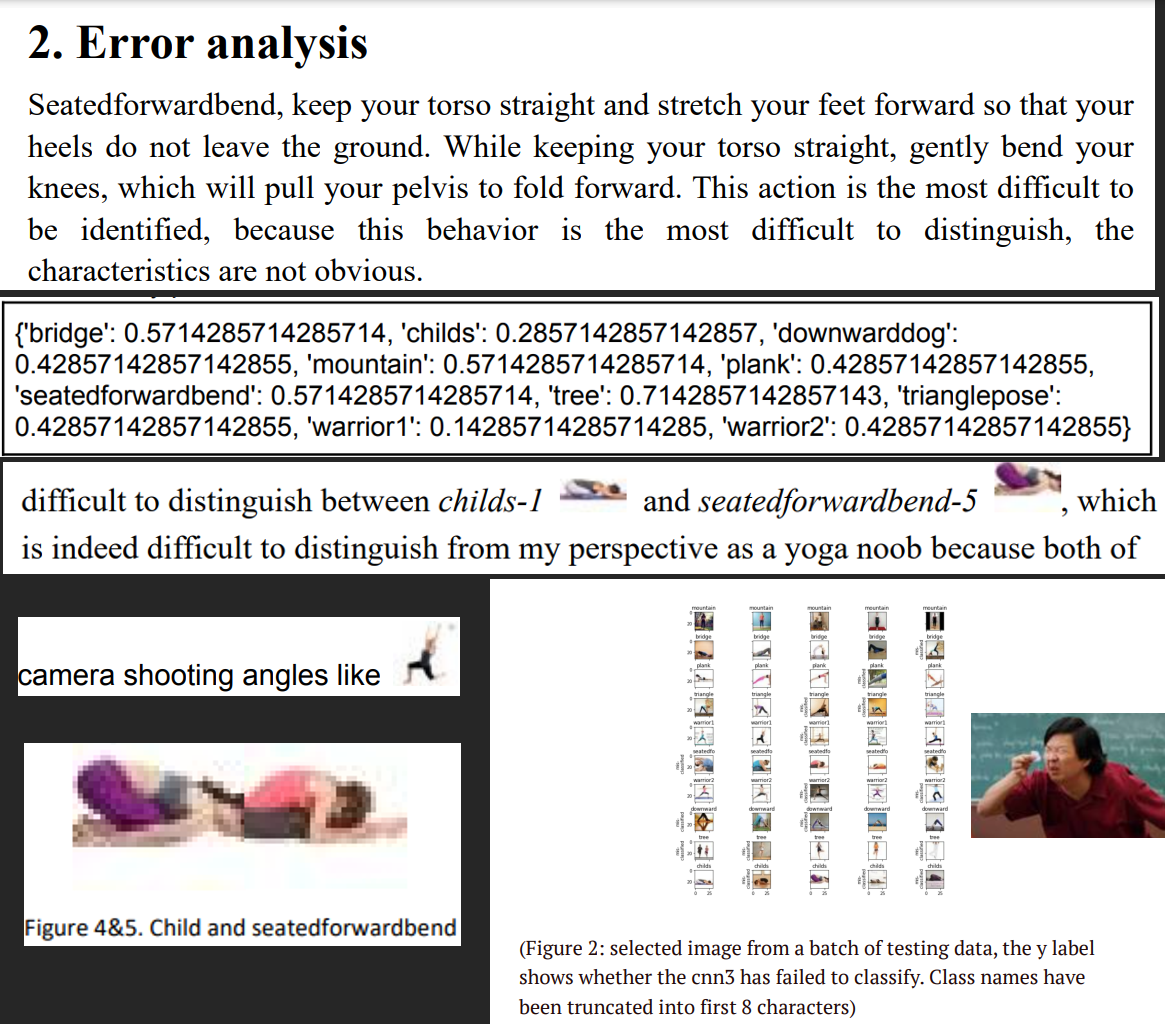

In [ ]:
# pip install tqdm    
## The tqdm library is used to display the progress bar. 
## Optional. If not to import tqdm, just modify the tqdm code in myutils.py

In [ ]:
# Includes importing some of custom packages
# The functions in the custom package are called via myutils.xxx
# e.g. the xx function needs to be called via myutils.xx 

import cv2
import os
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import myutils
import skimage.io
from skimage import data
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from tqdm import tqdm 

rootpath=path+'/Image/'

The first two algorithms (image quilting and texture synthesis) use different models for "texture". You do not need to know exactly how these two algorithms work. Instead, you are expected to visually compare and contrast the output of them.

## 1 Image quilting 

Image quilting is a method of synthesising a new image by stitching together small patches of existing images. It can be utilized for the following applications:

    (1) Texture synthesis: synthesize a new texture sample by taking patches of existing texture and stitching them together
    (2) Texture transfer: transfer the texture of one image onto another image

For more information, see the original publication [Image Quilting for Texture Synthesis and Transfer (Efros & Freeman, 2001)](https://people.eecs.berkeley.edu/~efros/research/quilting.html)

The following codes are adapted from https://github.com/axu2/image-quilting

### 1.1 Texture synthesis
Square blocks from the input texture are patched together to synthesize a new texture sample. We begin with randomly choose blocks.

![Imagequilting](https://upload.wikimedia.org/wikipedia/commons/b/bc/Imagequilting.gif)
<center>source:Drlanman</center>

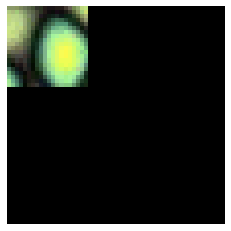

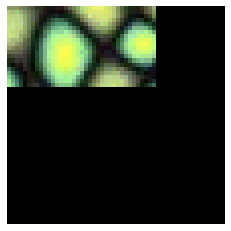

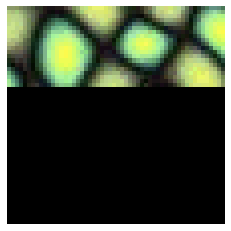

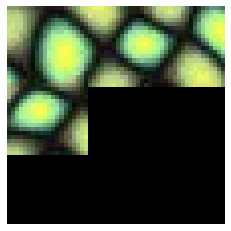

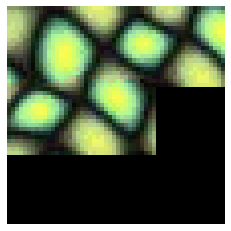

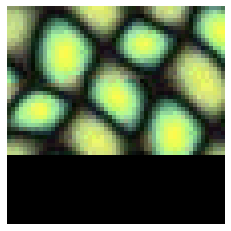

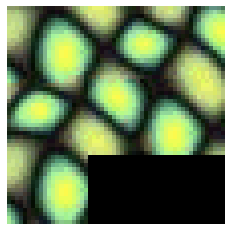

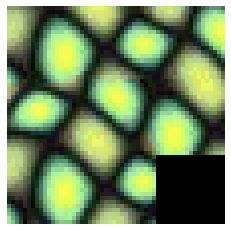

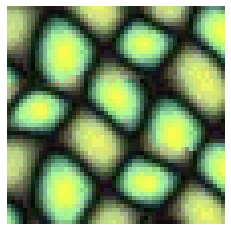

In [ ]:
# Display the process of texture synthesis
texture = cv2.imread(os.path.join(rootpath, "test.png"))
texture_rgb = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
patchsize = 20 # size of square patch for synthesis (overlap is 1/6 patch size)
npatch = 3# size of output (npatches x npatches)
showsteps = True # toggle image output for each step of synthesis
texture_synth = myutils.quilt(texture_rgb, patchsize, (npatch, npatch), "cut", showsteps)

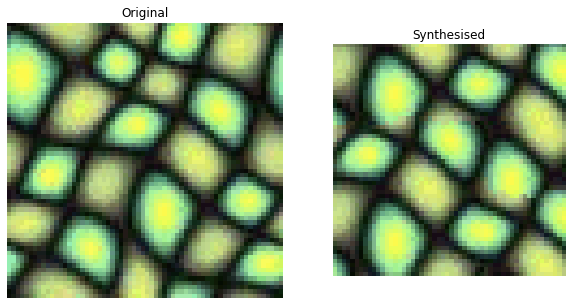

In [ ]:
# Display the synthesized and original image
plt.subplots(figsize=(10, 10))
#Set a grid layout to place subplots within a figure.
gs = gridspec.GridSpec(1, 2, width_ratios=[texture_rgb.shape[1], texture_synth.shape[1]])

plt.subplot(gs[0])
plt.imshow(texture_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(gs[1])
plt.imshow(texture_synth)
plt.title('Synthesised')
plt.axis('off')
plt.show()

### 1.2 Exercise

What is the effect of changing patch size in the texture synthesis?

Try a range of patch sizes for the "brick.jpg" and "marble.jpg" images. Note that if you use a very small patch size you may need to increase the number of patches (npatch) to get a large enough synthesis image to interpret the results. What range of patch sizes gives the best results for each image? What problems occur in the resulting synetheses if the patch size is too large or small in each case?

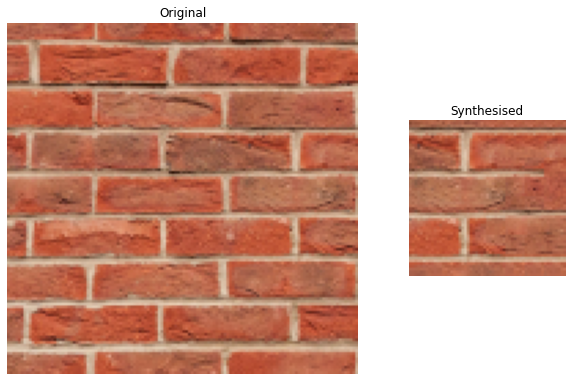

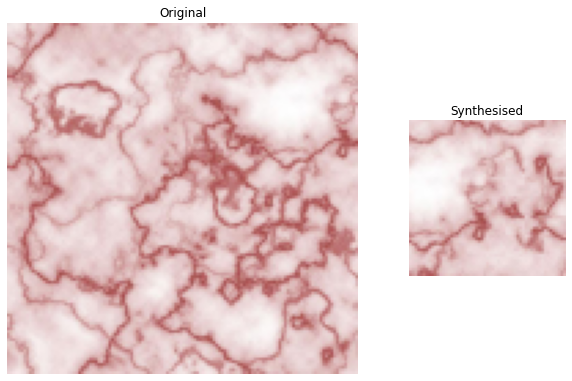

In [ ]:
# Read images
brick = cv2.imread(os.path.join(rootpath, "brick.jpg"))
brick_rgb = cv2.cvtColor(brick, cv2.COLOR_BGR2RGB)
marble = cv2.imread(os.path.join(rootpath, "marble.jpg"))
marble_rgb = cv2.cvtColor(marble, cv2.COLOR_BGR2RGB)

# Optional: Resize images for faster synthesis (original size = 256 x 256)
brick_rgb = cv2.resize(brick_rgb, (128, 128))
marble_rgb = cv2.resize(marble_rgb, (128, 128))

# Synthesize texture
patchsize = 8 # size of square patch for synthesis (overlap is 1/6 patch size)
npatch = 8 # size of output (npatches x npatches)
showsteps = False # toggle image output for each step of synthesis
brick_synth = myutils.quilt(brick_rgb, patchsize, (npatch, npatch), "cut", showsteps)
marble_synth = myutils.quilt(marble_rgb, patchsize, (npatch, npatch), "cut", showsteps)

# Display the synthesized and original image
plt.subplots(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[brick_rgb.shape[1], brick_synth.shape[1]])

plt.subplot(gs[0])
plt.imshow(brick_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(gs[1])
plt.imshow(brick_synth)
plt.title('Synthesised')
plt.axis('off')
plt.show()

# Display the synthesized and original image
plt.subplots(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[marble_rgb.shape[1], marble_synth.shape[1]])

plt.subplot(gs[0])
plt.imshow(marble_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(gs[1])
plt.imshow(marble_synth)
plt.title('Synthesised')
plt.axis('off')
plt.show()

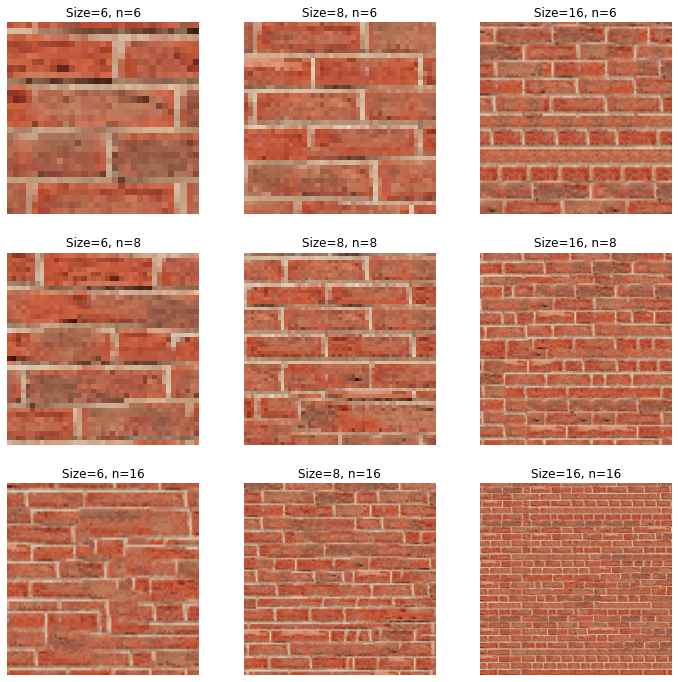

In [ ]:
# Read images
brick = cv2.imread(os.path.join(rootpath, "brick.jpg"))
brick_rgb = cv2.cvtColor(brick, cv2.COLOR_BGR2RGB)
marble = cv2.imread(os.path.join(rootpath, "marble.jpg"))
marble_rgb = cv2.cvtColor(marble, cv2.COLOR_BGR2RGB)

# Optional: Resize images for faster synthesis (original size = 256 x 256)
brick_rgb = cv2.resize(brick_rgb, (64, 64))
marble_rgb = cv2.resize(marble_rgb, (64, 64))

ss,ns = np.meshgrid([6,8,16],[6,8,16])
_,ax = plt.subplots(*ns.shape, figsize=(12,12))

for (x,y),_ in np.ndenumerate(ns):
    # Synthesize texture
    patchsize = ss[x,y] # size of square patch for synthesis (overlap is 1/6 patch size)
    npatch = ns[x,y] # size of output (npatches x npatches)
    showsteps = False # toggle image output for each step of synthesis
    brick_synth = myutils.quilt(brick_rgb, patchsize, (npatch, npatch), "cut", showsteps)

    ax[x,y].imshow(brick_synth)
    ax[x,y].set_title(f'Size={patchsize}, n={npatch}')
    ax[x,y].axis('off')
plt.show()

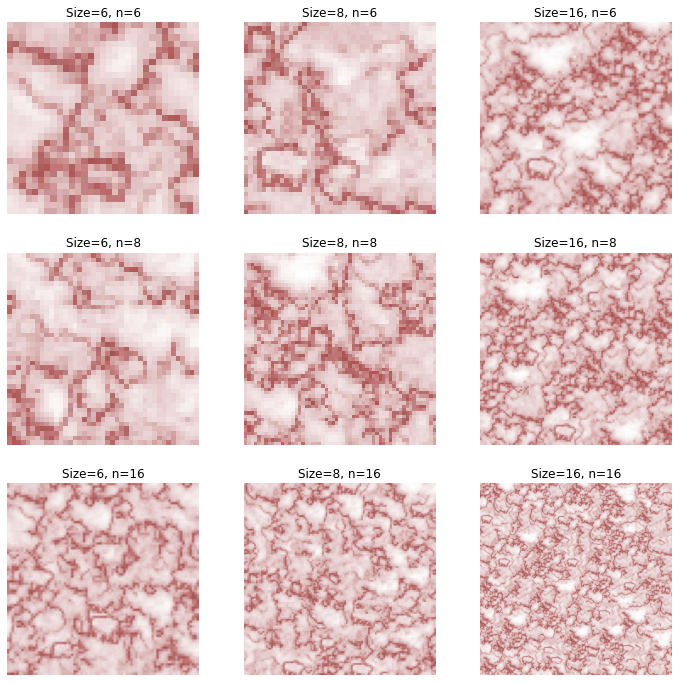

In [ ]:
_,ax = plt.subplots(*ns.shape, figsize=(12,12))

for (x,y),_ in np.ndenumerate(ns):
    # Synthesize texture
    patchsize = ss[x,y] # size of square patch for synthesis (overlap is 1/6 patch size)
    npatch = ns[x,y] # size of output (npatches x npatches)
    showsteps = False # toggle image output for each step of synthesis
    marble_synth = myutils.quilt(marble_rgb, patchsize, (npatch, npatch), "cut", showsteps)

    ax[x,y].imshow(marble_synth)
    ax[x,y].set_title(f'Size={patchsize}, n={npatch}')
    ax[x,y].axis('off')
plt.show()

## 2 Parametric texture synthesis

Different from the previous algorithm, which considers texture as repeated image patch, this algorithm models texture as a sample from a statistical distribution over image features. For more information, see the original publication [A Parametric Texture Model based on Joint Statistics of Complex Wavelet Coefficients(Portilla & Simoncelli, 2000)](http://www.cns.nyu.edu/~eero/ABSTRACTS/portilla99-abstract.html).

The following codes are adapted from https://github.com/TetsuyaOdaka/texture-synthesis-portilla-simoncelli

You can run this algorithm on colour or grayscale images. The colour version takes about 3x longer to run than the grayscale version.

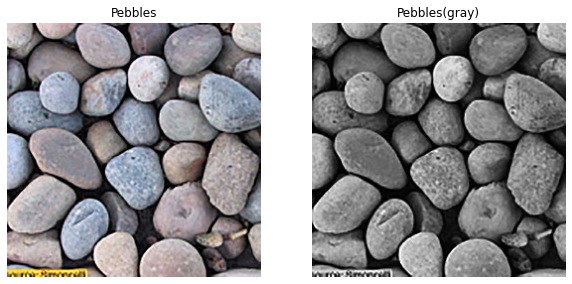

In [ ]:
# Read in images
pebbles =  cv2.imread(os.path.join(rootpath, "pebbles.jpg"))
pebbles2 = cv2.imread(os.path.join(rootpath, "pebbles_gray.jpg"))

pebbles_rgb = cv2.cvtColor(pebbles, cv2.COLOR_BGR2RGB)
pebbles_gray = cv2.cvtColor(pebbles2, cv2.COLOR_BGR2GRAY)

# Display the loaded images
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(pebbles_rgb)
plt.title('Pebbles')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(pebbles_gray, cmap='gray')
plt.title('Pebbles(gray)')
plt.axis('off')
plt.show()

### 2.1 Colour texture synthesis

In [ ]:
# Execute RGB colour version
myutils.run_texture_synthesis(num_neighbor= 7, #local neighborhood
                              orig_img='./Image/pebbles.jpg', #Original RGB image
                              num_depth= 5, #depth of steerable pyramid
                              num_ori= 4, #orientation of steerable pyramid
                              num_iter= 25, #number of iterations
                              out_dir='output_rgb') #Output directory

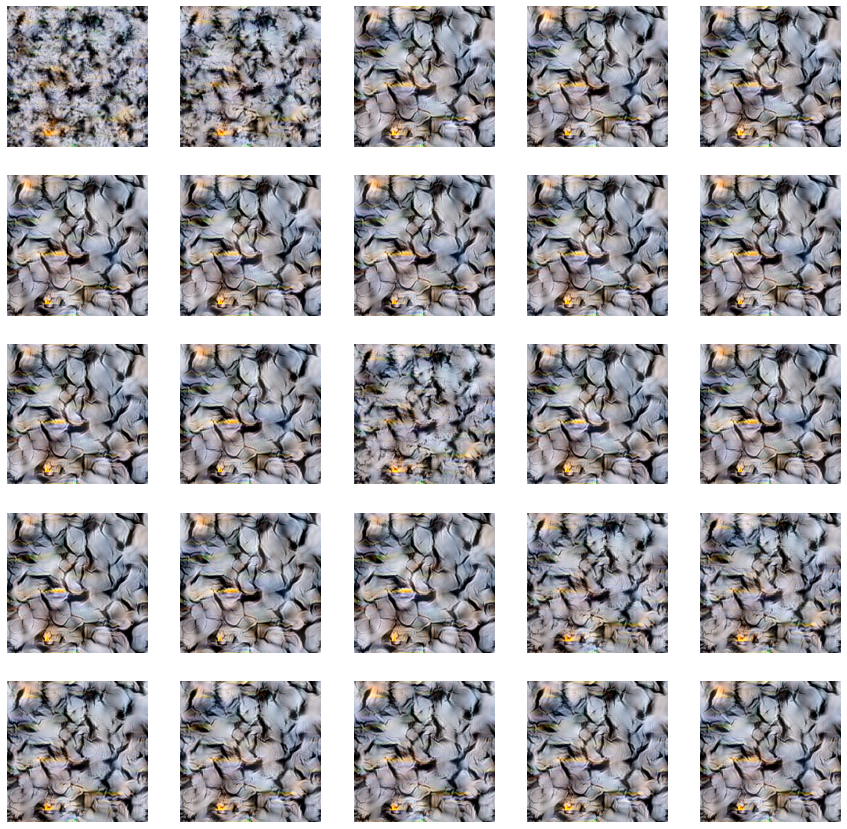

In [ ]:
# Display the step-by-step results
output_rgb_lst = os.listdir(path+'output_rgb')
output_rgb_lst.sort()
_,ax = plt.subplots(5,5,figsize=(15,15))
for n,i in enumerate(output_rgb_lst):
    output_rgb_img = cv2.imread(path+"output_rgb/"+i)
    output_rgb = cv2.cvtColor(output_rgb_img, cv2.COLOR_BGR2RGB)
    ax[n//5,n%5].imshow(output_rgb)
    ax[n//5,n%5].axis('off')
plt.show()

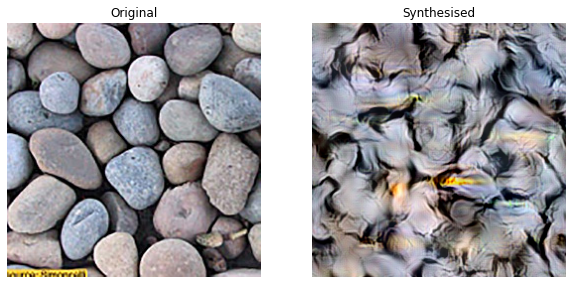

In [ ]:
# Display the original and final synthesis
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(pebbles_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(output_rgb)
plt.title('Synthesised')
plt.axis('off')
plt.show()

### 2.2 Grayscale texture synthesis

In [ ]:
# Execute Gray Scale Version
myutils.run_texture_synthesis_g(num_neighbor= 7, #local neighborhood
                              orig_img= path+'/Image/pebbles_gray.jpg', #Original grayscale image
                              num_depth= 5, #depth of steerable pyramid
                              num_ori= 4, #orientation of steerable pyramid
                              num_iter= 25, #number of iterations
                              out_dir='output_gray') #Output directory

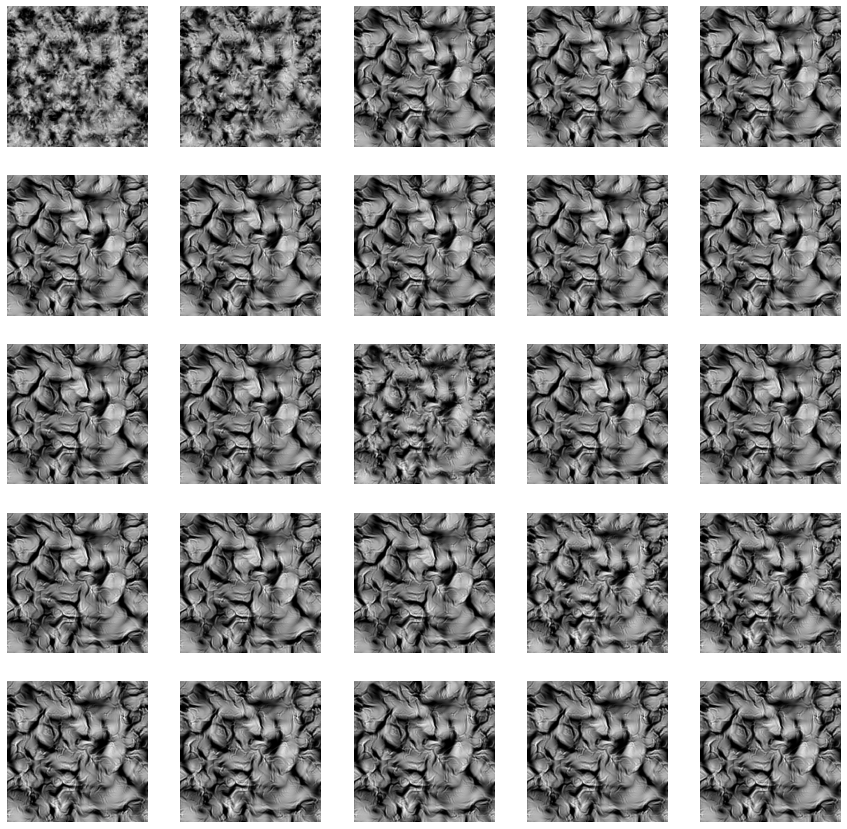

In [ ]:
# Display the step-by-step results
output_gray_lst = os.listdir(path+'output_gray')
output_gray_lst.sort()

_,ax = plt.subplots(5,5,figsize=(15,15))
for n,i in enumerate(output_gray_lst):
    output_gray_img = cv2.imread("output_gray/"+i, cv2.IMREAD_GRAYSCALE)
    ax[n//5,n%5].imshow(output_gray_img, cmap='gray')
    ax[n//5,n%5].axis('off')
plt.show()

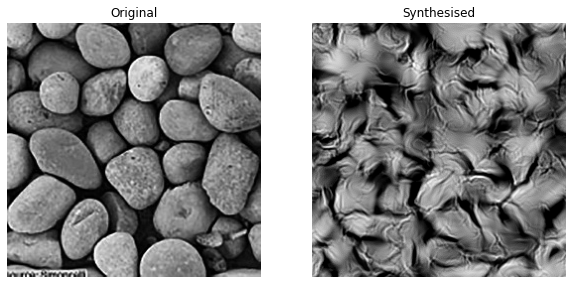

In [ ]:
# Display the original and final synthesis
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(pebbles_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(output_gray_img, cmap='gray')
plt.title('Synthesised')
plt.axis('off')
plt.show()

### 2.3 Exercise

Run the parametric synthesis on the "brick.jpg" and "water.jpg" textures. What problems (if any) do you observe in the resulting syntheses? Which image is more easily synthesized by the parametric approach and why?

**Note:** for faster results, you may wish to use the grayscale version of the algorithm.

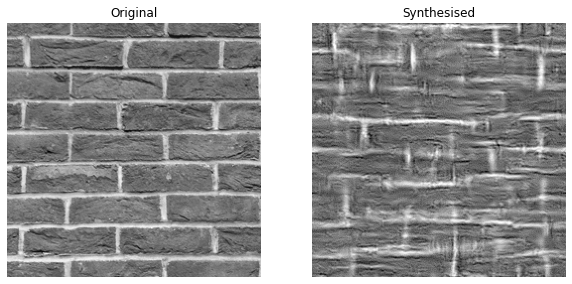

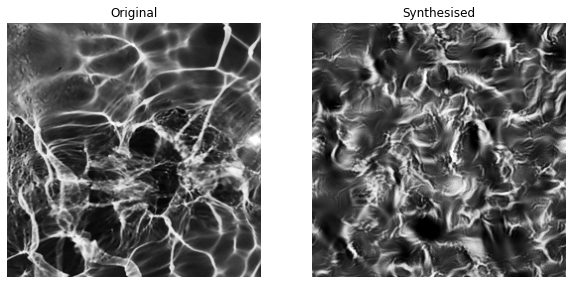

In [ ]:
# Read images
use_color = 0
if use_color:
    brick = cv2.imread(os.path.join(rootpath, "brick.jpg"))
    brick_orig = cv2.cvtColor(brick, cv2.COLOR_BGR2RGB)
    water = cv2.imread(os.path.join(rootpath, "water.jpg"))
    water_orig = cv2.cvtColor(water, cv2.COLOR_BGR2RGB)
else:
    brick = cv2.imread(os.path.join(rootpath, "brick_gray.jpg"))
    brick_orig = cv2.cvtColor(brick, cv2.COLOR_BGR2GRAY)
    water = cv2.imread(os.path.join(rootpath, "water_gray.jpg"))
    water_orig = cv2.cvtColor(water, cv2.COLOR_BGR2GRAY)

# Execute synthesis
num_iter = 25;
if not os.path.isdir("brick_gray"):
    os.makedirs("brick_gray")
myutils.run_texture_synthesis_g(num_neighbor= 7, #local neighborhood
                              orig_img= './Image/brick_gray.jpg', #Original grayscale image
                              num_depth= 5, #depth of steerable pyramid
                              num_ori= 4, #orientation of steerable pyramid
                              num_iter= num_iter, #number of iterations
                              out_dir='brick_gray') #Output directory
output_gray_lst = os.listdir("brick_gray")
output_gray_lst.sort()
brick_synth = cv2.imread("brick_gray/"+output_gray_lst[num_iter-1], cv2.IMREAD_GRAYSCALE)

if not os.path.isdir("water_gray"):
    os.makedirs("water_gray")
myutils.run_texture_synthesis_g(num_neighbor= 7, #local neighborhood
                              orig_img= './Image/water_gray.jpg', #Original grayscale image
                              num_depth= 5, #depth of steerable pyramid
                              num_ori= 4, #orientation of steerable pyramid
                              num_iter= num_iter, #number of iterations
                              out_dir='water_gray') #Output directory
output_gray_lst = os.listdir("water_gray")
output_gray_lst.sort()
water_synth = cv2.imread("water_gray/"+output_gray_lst[num_iter-1], cv2.IMREAD_GRAYSCALE)

# Display the original and final synthesis
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(brick_orig, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(brick_synth, cmap='gray')
plt.title('Synthesised')
plt.axis('off')
plt.show()

# Display the original and final synthesis
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(water_orig, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(water_synth, cmap='gray')
plt.title('Synthesised')
plt.axis('off')
plt.show()

## 3 Neural style transfer

Neural style transfer allows two images (one with content and one with style) to compose new artwork.

- [Online demo](https://tenso.rs/demos/fast-neural-style/)

    This online demo allows faster demonstration of style-transfer neural network.

### 3.1 Exercise

- [An implementation of neural style transfer (view in Google Colab)](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/neural_style_transfer.ipynb)

    Please refer to the Neural style transfer tutorial from [Keras](https://keras.io/examples/generative/neural_style_transfer/) for a detailed implement. Note that it may take about 10 minutes to run all the code on the Google Colab with **free GPU**. To speed up, use a smaller `iterations` in `The training loop`.

## 4 Shape skeletons

The topological skeleton of a shape is the thinnest possible version of a shape, composed of points equidistant from the shape boundaries. There are many different ways to compute shape skeletons, but this method uses the medial axis method based on the [grassfire transform](https://en.wikipedia.org/wiki/Grassfire_transform) shown in lecture. The shape skeleton plus the distance from the skeleton pixel to the shape boundary is a complete representation of the shape.

For more information on the functions used below, see:
- [`skimage.morphology.medial_axis( )`](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.medial_axis)

`from skimage.morphology import skeletonize`

[Skeletonization](https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html) reduces binary objects to 1 pixel wide representations.

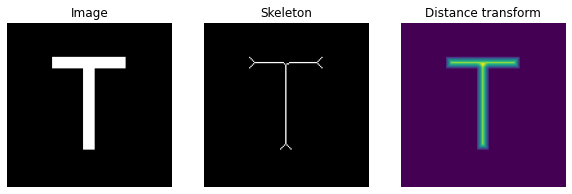

In [ ]:
# Read in image
image = skimage.io.imread(fname=os.path.join(rootpath, "T.png"))
# Skeletonisation requires a binary image (1=shape pixel, 0=background)
binary_image = (image > 0)
skel = skeletonize(binary_image)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(image, return_distance=True)

# Display the image, skeleton, and distance transform
plt.subplots(figsize=(10, 10))

plt.subplot(1,3,1)
plt.imshow(binary_image, cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(skel, cmap='gray')
plt.title('Skeleton')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(distance)
plt.title('Distance transform')
plt.axis('off')
plt.show()

### 4.1 Exercise

Write a method to reconstruct the shape using the skeleton and distance transform.

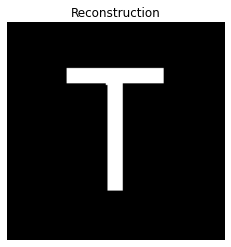

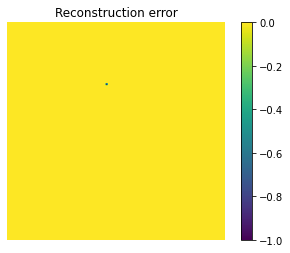

In [ ]:
from scipy import ndimage

reconstruction = np.zeros(skel.shape)
ind = np.nonzero(skel)
for (x,y) in zip(*ind):
    mask = np.zeros(skel.shape)
    mask[x,y] = 1
    radius = distance[x,y]
    disk = skimage.morphology.disk(radius-0.1)
    mask = ndimage.convolve(mask,disk,mode='nearest')
    reconstruction = np.maximum(reconstruction,mask)
reconstruction = (reconstruction > 0)

# Display the reconstruction
plt.imshow(reconstruction, cmap='gray')
plt.title('Reconstruction')
plt.axis('off')
plt.show()

# Display the reconstruction error
err = plt.imshow(binary_image.astype(float)-reconstruction.astype(float))
plt.title('Reconstruction error')
plt.colorbar(err)
plt.axis('off')
plt.show()

# The reconstruction may have some errors at the boundary due to rounding

## 5 Active contours
The active contour model, also called snakes, is a method to fit open or closed splines to lines or edges in an image [1]. It works by minimising an energy that is in part defined by the image and part by the spline's shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy.

> [1] *Snakes: Active contour models*. Kass, M.; Witkin, A.; Terzopoulos, D.
       International Journal of Computer Vision 1 (4): 321 (1988).
       DOI: `10.1007/BF00133570`


Adapted from [Active Contour Model — skimage v0.19.0.dev0 docs](https://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html)


#### (1) Segment the face of a person from the rest of an image by fitting a closed curve to the edges of the face

We initialize a circle around the astronaut's face and use the default boundary
condition ``boundary_condition='periodic'`` to fit a closed curve. The default
parameters ``w_line=0, w_edge=1`` will make the curve search towards edges,
such as the boundaries of the face.

For more information on the functions used below, see:
- [`skimage.segmentation.active_contour( )`](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.active_contour)

0.18.3


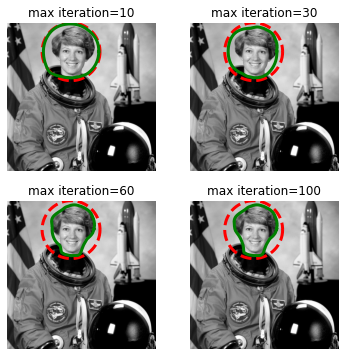

In [ ]:
# Get astronaut from skimage.data in grayscale
img = rgb2gray(data.astronaut())

# Check skimage version because the active contours method changed in v18
print(skimage.__version__)
version_text = (skimage.__version__).split('.')
version = int(version_text[1])
current = 18

# Draw a circle around the astronaut's head to initialize the snake
s = np.linspace(0, 2*np.pi, 400) # init will calculate 400 such points
if version < current:
    x = 220 + 100*np.cos(s)
    y = 100 + 100*np.sin(s)
    init = np.array([x, y]).T
else:
    r = 100 + 100*np.sin(s)
    c = 220 + 100*np.cos(s)
    init = np.array([r, c]).T 

# Display results of different maximum iterations to optimize snake shape
i = 1
plt.subplots(figsize=(6, 6)) 
for max_it in [10, 30, 60, 100]:
    snake = active_contour(gaussian(img, sigma=3), #Smooth image. sigma is standard deviation for Gaussian kernel.
                           init, #Initial snake coordinates
                           alpha=0.015, #Snake length shape parameter. Higher values makes snake contract faster.
                           beta=10, #Snake smoothness shape parameter. Higher values makes snake smoother.
                           w_line=0, #Controls attraction to brightness.
                           w_edge=1, #Controls attraction to edges. Use negative values to repel snake from edges.
                           gamma=0.001, #Explicit time stepping parameter.
                           max_iterations=max_it, #Maximum iterations toSmooth image before analyzing. sigma means standard deviation for Gaussian kernel.Smooth image before analyzing. sigma means standard deviation for Gaussian kernel. optimize snake shape.
                           boundary_condition='periodic') # 'periodic' to fit a closed curve
    plt.subplot(2,2,i) 
    plt.imshow(img, cmap='gray')
    if version < current:
        plt.plot(init[:, 0], init[:, 1], '--r', lw=3) # initial circle - the dotted red circle
        plt.plot(snake[:, 0], snake[:, 1], '-g', lw=3) # optimized snake shape - green lines
    else:
        plt.plot(init[:, 1], init[:, 0], '--r', lw=3) # initial circle - the dotted red circle
        plt.plot(snake[:, 1], snake[:, 0], '-g', lw=3) # optimized snake shape - green lines
    plt.title('max iteration=' + str(max_it))
    plt.axis('off')
    i += 1

plt.show()

### 5.1 Exercise

What happens as you increase or decrease the alpha and beta parameters? Why?

Remember:
$$𝐸_{𝑡𝑜𝑡𝑎𝑙} =𝛼𝐸_{𝑒𝑙𝑎𝑠𝑡𝑖𝑐𝑖𝑡𝑦} +𝛽𝐸_{𝑠𝑡𝑖𝑓𝑓𝑛𝑒𝑠𝑠} +𝐸_{𝑒𝑑𝑔𝑒}$$

- $𝐸_{𝑒𝑙𝑎𝑠𝑡𝑖𝑐𝑖𝑡𝑦}$ is based on contour length, penalises 
longer contours
- $𝐸_{𝑠𝑡𝑖𝑓𝑓𝑛𝑒𝑠𝑠}$ is based on contour curvature, lowest for 
straight contour segments
- $𝐸_{𝑒𝑑𝑔𝑒}$ is based on image gradient at contour 
locations, lowest where image gradient is highest
- 𝛼, 𝛽 are free parameters

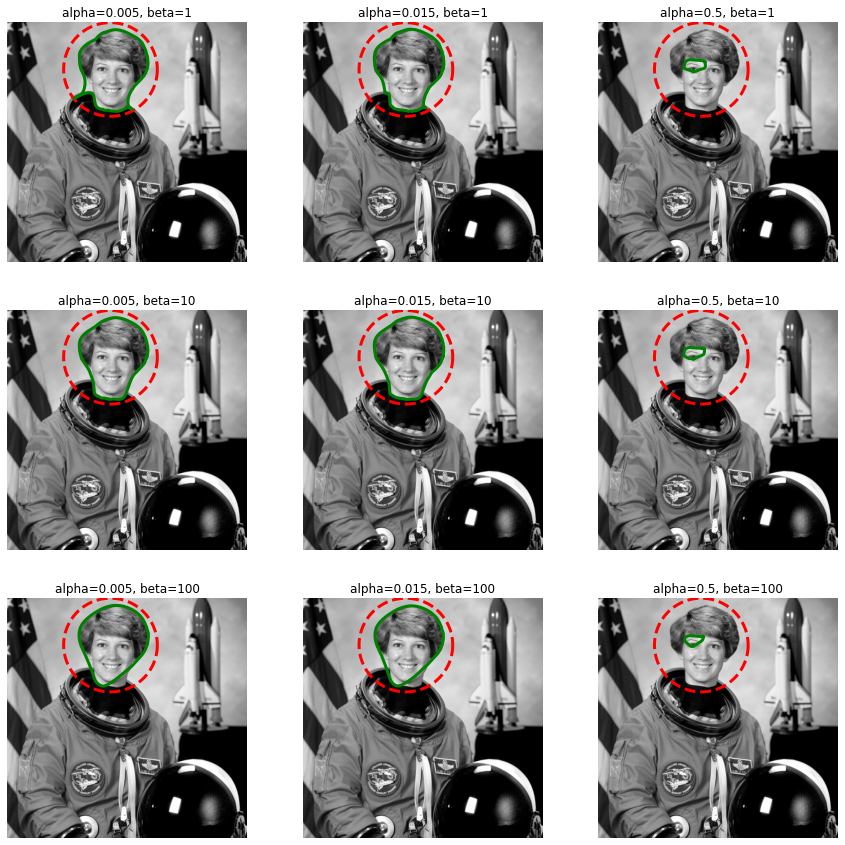

In [ ]:
# Get astronaut from skimage.data in grayscale
img = rgb2gray(data.astronaut())
# Draw a circle around the astronaut's head to initialize the snake
s = np.linspace(0, 2*np.pi, 400) # init will calculate 400 such points
if version < current:
    x = 220 + 100*np.cos(s)
    y = 100 + 100*np.sin(s)
    init = np.array([x, y]).T
else:
    r = 100 + 100*np.sin(s)
    c = 220 + 100*np.cos(s)
    init = np.array([r, c]).T 

als,bs = np.meshgrid([0.005,0.015,0.5],[1,10,100])
_,ax = plt.subplots(*bs.shape, figsize=(15,15))

for (x,y),n in np.ndenumerate(bs):
    snake = active_contour(gaussian(img, sigma=3), #Smooth image. sigma is standard deviation for Gaussian kernel.
                           init, #Initial snake coordinates
                           alpha=als[x,y], #Snake length shape parameter. Higher values makes snake contract faster.
                           beta=bs[x,y], #Snake smoothness shape parameter. Higher values makes snake smoother.
                           w_line=0, #Controls attraction to brightness.
                           w_edge=1, #Controls attraction to edges. Use negative values to repel snake from edges.
                           gamma=0.001, #Explicit time stepping parameter.
                           max_iterations=100, #Maximum iterations toSmooth image before analyzing. sigma means standard deviation for Gaussian kernel.Smooth image before analyzing. sigma means standard deviation for Gaussian kernel. optimize snake shape.
                           boundary_condition='periodic') # 'periodic' to fit a closed curve 
    ax[x,y].imshow(img, cmap='gray')
    if version < current:
        ax[x,y].plot(init[:, 0], init[:, 1], '--r', lw=3) # initial circle - the dotted red circle
        ax[x,y].plot(snake[:, 0], snake[:, 1], '-g', lw=3) # optimized snake shape - green lines
    else:
        ax[x,y].plot(init[:, 1], init[:, 0], '--r', lw=3) # initial circle - the dotted red circle
        ax[x,y].plot(snake[:, 1], snake[:, 0], '-g', lw=3) # optimized snake shape - green lines
    ax[x,y].set_title(f'alpha={als[x,y]}, beta={bs[x,y]}')
    ax[x,y].axis('off')

plt.show()

## Bonus: Texture transfer with image quilting

Rendering an object with a texture taken from a different object.

### 6.1 Texture transfer example 1

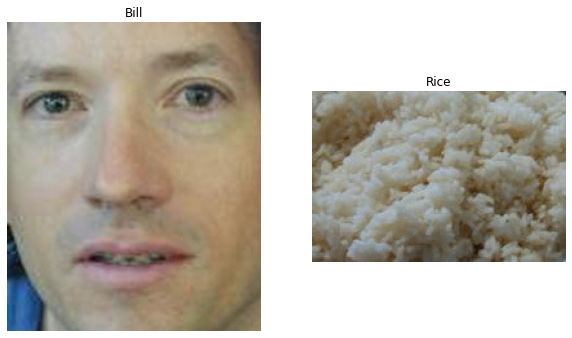

In [ ]:
# Read in images
bill =  cv2.imread(os.path.join(rootpath, "bill-big.jpg"))
rice = cv2.imread(os.path.join(rootpath, "rice.png"))

bill_rgb = cv2.cvtColor(bill, cv2.COLOR_BGR2RGB)
rice_rgb = cv2.cvtColor(rice, cv2.COLOR_BGR2RGB)

# Display the loaded images
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(bill_rgb)
plt.title('Bill')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rice_rgb)
plt.title('Rice')
plt.axis('off')
plt.show()

100%|███████████████████████████████████████████| 17/17 [02:24<00:00,  8.51s/it]


finish transfer...
(0.9, 13)


100%|███████████████████████████████████████████| 26/26 [07:20<00:00, 16.93s/it]


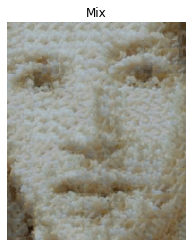

In [ ]:
# Perform texture transfer
# Note: May take about 10-15 minutes to complete.
res2 = myutils.transferIter(rice_rgb, bill_rgb, 20, 2)

# Display the result of texture transfer
plt.imshow(res2)
plt.title('Mix')
plt.axis('off')
plt.show()

### 6.2 Texture transfer example 2

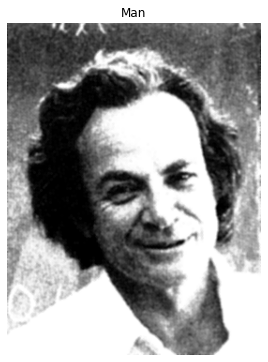

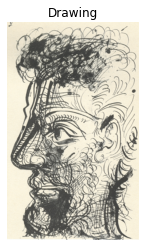

In [ ]:
# Read in images
man =  cv2.imread(os.path.join(rootpath, "man.png"))
drawing = cv2.imread(os.path.join(rootpath, "drawing.png"))

man_rgb = cv2.cvtColor(man, cv2.COLOR_BGR2RGB)
drawing_rgb = cv2.cvtColor(drawing, cv2.COLOR_BGR2RGB)

# Display the loaded images
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.imshow(man_rgb)
plt.title('Man')
plt.axis('off')
plt.show()

plt.subplot(1,2,2)
plt.imshow(drawing_rgb)
plt.title('Drawing')
plt.axis('off')
plt.show()

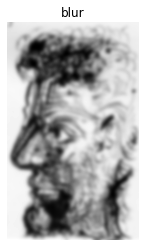

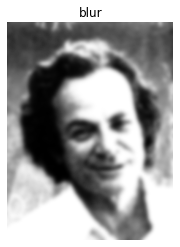

100%|███████████████████████████████████████████| 21/21 [12:40<00:00, 36.24s/it]


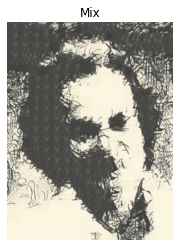

In [ ]:
# Perform texture transfer
# Note: May take about 10-15 minutes to complete.
res3 = myutils.transfer(drawing_rgb, man_rgb, 20, blur=True)

# Display the result of texture transfer
plt.imshow(res3)
plt.title('Mix')
plt.axis('off')
plt.show()